In [1]:
import numpy as np
from scipy import integrate
import torch

import matplotlib
import matplotlib.pyplot as plt

from probability_distribution import mu_gaussians, mu_display2D
from fourier_functions import Fourier_Functions, Fourier_Functions_Visualize2D
import pickle 

4.006529739295107e-05


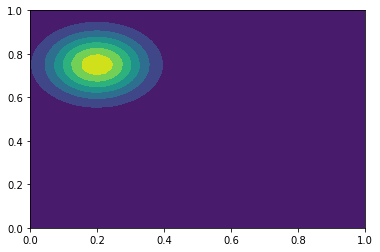

In [2]:
U_shape = (1,1)
p1 = mu_gaussians([(np.array([0.2, 0.75]), 0.02)], U_shape)
print(p1(np.array([0.2,0.3])))
mu_display2D(p1, U_shape)

In [9]:
mu = p1
K = 3 #5
ff = Fourier_Functions(mu, U_shape, K, compute_mu=False, printProgress=True)

# mu_k = {}
# for k in ff:
#     mu_k[k] = ff[k]['mu_k']

# with open('one_mu_k5.pkl', 'wb') as handle:
#     pickle.dump(mu_k, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(f'one_mu_k{K}.pkl', 'rb') as handle:
    mu_k = pickle.load(handle)
for k in ff:
    # print(k)
    ff[k]['mu_k'] = mu_k[k]
    print(ff[k]['mu_k'])
    # print(ff[k]["lambda_k"])
    # Fourier_Functions_Visualize2D(U_shape, ff[k])



Fourier Functions (mu, U_shape= (1, 1) , K= 5 )...
Computing constants (new_k, h_k, lambda_k)...
Computing torch fourier functions (f_k, df_k)...
Computing casadi fourier function (casadi_f_k)...
Aggregating all constants and functions into one dict...
Done.
0.061021131644699994
-0.057911760163322994
-0.0005192567962496389
0.03987819611676822
-0.03989295419399945
0.06601700328291758
-0.06265306391042154
-0.0005617689593546989
0.04314307081825778
-0.043159037156586165
0.020487888284750056
-0.019443914601712468
-0.00017434083809856482
0.01338913266628453
-0.013394087701195576
-0.019302205399686325
0.01831864895981361
0.00016425131862109684
-0.012614271673896267
0.012618939949137053
-0.03409650163685005
0.032359092202661824
0.0002901427706447569
-0.022282559213863958
0.022290805517905028


In [4]:
def ergodic_metric(ff, c_k, k_bands):
    e = 0
    for k in k_bands:
        e += ff[k]['lambda_k']*(ff[k]['mu_k'] - c_k[k])**2
    return e 

class Agent:
    def __init__(self, x_init, dynamics, k_bands):
        # dynamics(x, u)
        self.k_bands = k_bands
        self.trajectory = [x_init]
        self.c_k = [{k: ff[k]['f_k'](x_init) for k in self.k_bands}]
        self.ergodicity = [ergodic_metric(ff, self.c_k[-1], self.k_bands)]
        self.dynamics = dynamics

In [5]:
def simple_dynamics(x, u):
    return x + u
agent = Agent(np.array([0.2, 0.3]), simple_dynamics, list(np.ndindex(*[K]*2)))

for k in agent.k_bands:
    print(k)

(0, 0)
(0, 1)
(0, 2)
(0, 3)
(0, 4)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(1, 4)
(2, 0)
(2, 1)
(2, 2)
(2, 3)
(2, 4)
(3, 0)
(3, 1)
(3, 2)
(3, 3)
(3, 4)
(4, 0)
(4, 1)
(4, 2)
(4, 3)
(4, 4)


In [6]:
num_iterations = 100

u_max = 0.05
eps = 0.05

for n_i in range(num_iterations):
    # control 
    B = sum([ff[k]['lambda_k']*n_i*(agent.c_k[-1][k] - ff[k]['mu_k'])*ff[k]['df_k'](agent.trajectory[-1]) for k in agent.k_bands])
    if np.linalg.norm(B) == 0:
        B = np.array([1, 1])
        print("zero control")
    u = -u_max*B/np.linalg.norm(B)
    projected_x = agent.dynamics(agent.trajectory[-1], u)
    if (projected_x < 0).any() or (projected_x > U_shape).any():
        print("was going to go out of bounds")
        break 

    # update position, c_k, ergodicity
    previous_x = agent.trajectory[-1]
    agent.trajectory.append(projected_x)
    new_c_k = {k: (n_i*agent.c_k[-1][k] + (ff[k]['f_k'](previous_x) + ff[k]['f_k'](projected_x))/2)/(n_i+1) for k in agent.k_bands}
    agent.c_k.append(new_c_k)
    agent.ergodicity.append(ergodic_metric(ff, agent.c_k[-1], agent.k_bands))

zero control


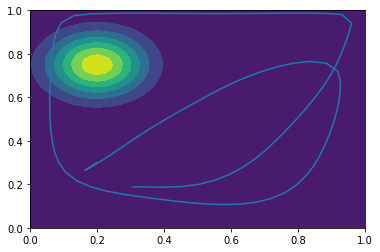

In [7]:
mu_display2D(p1, U_shape)
plt.plot([pos[0] for pos in agent.trajectory], [pos[1] for pos in agent.trajectory])


KeyboardInterrupt: 

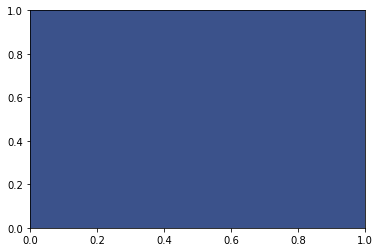

<Figure size 432x288 with 0 Axes>

In [8]:
for k in agent.k_bands:
    mu_display2D(ff[k]['f_k'], U_shape)

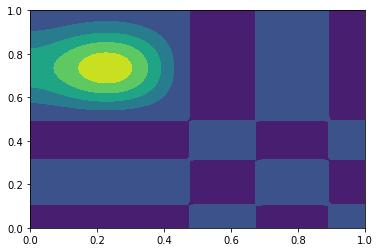

In [ ]:
def recon_mu(x):
    return sum([ff[k]['mu_k']*ff[k]['f_k'](x) for k in agent.k_bands])
mu_display2D(recon_mu, U_shape)

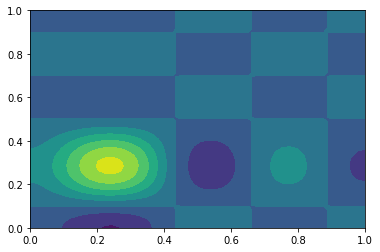

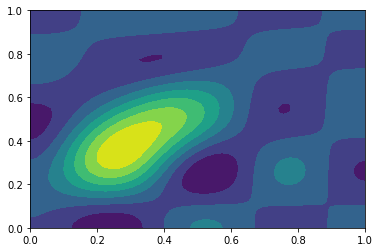

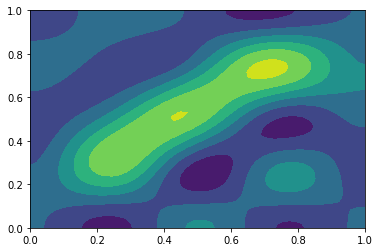

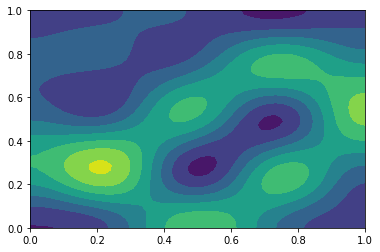

In [ ]:
for i in [0, 10, 20, 50]:
    def recon_c_k(x):
        return sum([agent.c_k[i][k]*ff[k]['f_k'](x) for k in agent.k_bands])
    mu_display2D(recon_c_k, U_shape)